In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Deep Learning Libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dense, RepeatVector, TimeDistributed
from keras.optimizers import Adam

# Prophet
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [2]:
%load_ext memory_profiler
%memit

# Reading the Data
df = pd.read_csv("historical_daily_stockprice_GOOGL.csv")

# Preprocessing
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.sort_values('Datetime', inplace=True)
df.set_index('Datetime', inplace=True)

# Feature Engineering
df['Close_Open'] = df['Close'] - df['Open']
data = df[['Close_Open']]

# Handle Missing Values (if any)
data = data.dropna()

data.head()


peak memory: 451.65 MiB, increment: 0.16 MiB


,Close_Open
Datetime,
2015-02-12,0.31
2015-02-13,0.19
2015-02-17,-0.31
2015-02-18,-0.06
2015-02-19,0.20


In [3]:
# Split the dataframe into training and testing sets
train_size = int(len(data) * 0.8)
data_train, data_test = data[:train_size], data[train_size:]

In [4]:
data_train.shape

(2010, 1)

In [7]:


# Function to create sequences for LSTMs, GRUs, TCNs
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length)].values
        y = data.iloc[i+seq_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30  # Adjust this based on your needs
X, y= create_sequences(data_train, seq_length)
#X_test, y_test = create_sequences(test, seq_length)




In [8]:
X = X.reshape((X.shape[0], X.shape[1], 1))  # reshape to (samples, timesteps, features)
print(X.shape, y.shape)


(1980, 30, 1) (1980,)


In [9]:
# Split into train/test
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]



In [10]:

X_test, y_test= create_sequences(data_test, seq_length)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))  # reshape to (samples, timesteps, features)
print(X_test.shape, y_test.shape)

(473, 30, 1) (473,)


In [11]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

lstm_model = build_lstm_model(X.shape[1:])
lstm_model.summary()


C:\Users\PC\.venvs\venv_py_3_11\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
lstm_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.5906 - val_loss: 4.1302
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5681 - val_loss: 4.1620
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.6156 - val_loss: 4.1949
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5423 - val_loss: 4.1992
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5515 - val_loss: 4.2156
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5823 - val_loss: 4.2209
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5778 - val_loss: 4.2273
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.5533 - val_loss: 4.2557
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.5381 - val_loss: 4.2460
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5652 - val_loss: 4.2511


In [13]:
pred_Y = lstm_model.predict(X_test)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [14]:
print(pred_Y.shape)
print(y_test.shape)

(473, 1)
(473,)


In [15]:
print("MSE: ", mean_squared_error(y_test, pred_Y))

MSE:  3.832733141268228


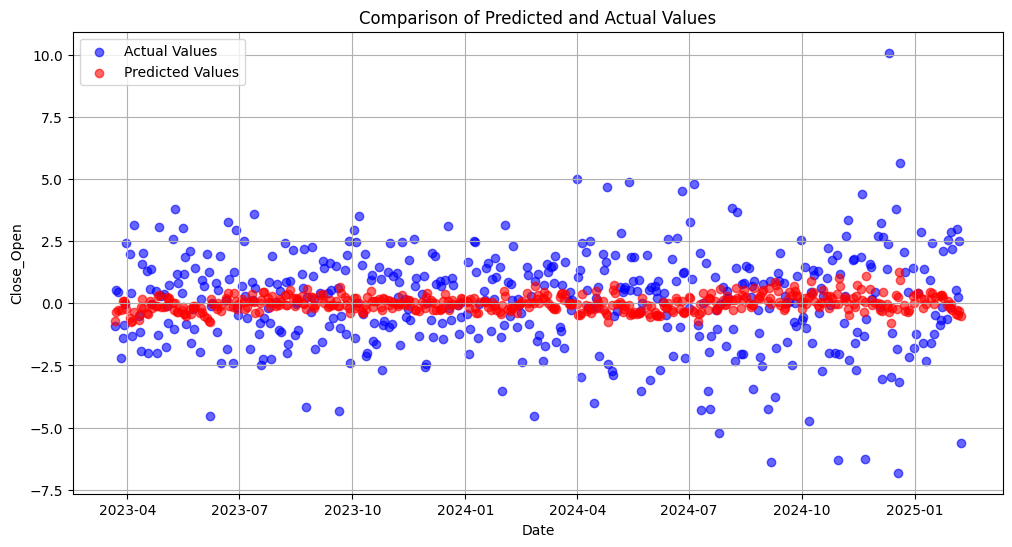

In [16]:
# Scatter plot to compare predictions with actual values in data_test

plt.figure(figsize=(12, 6))
plt.scatter(data_test.index[seq_length:], y_test, label="Actual Values", color="blue", alpha=0.6)
plt.scatter(data_test.index[seq_length:], pred_Y.flatten(), label="Predicted Values", color="red", alpha=0.6)
plt.title("Comparison of Predicted and Actual Values")
plt.xlabel("Date")
plt.ylabel("Close_Open")
plt.legend()
plt.grid(True)
plt.show()

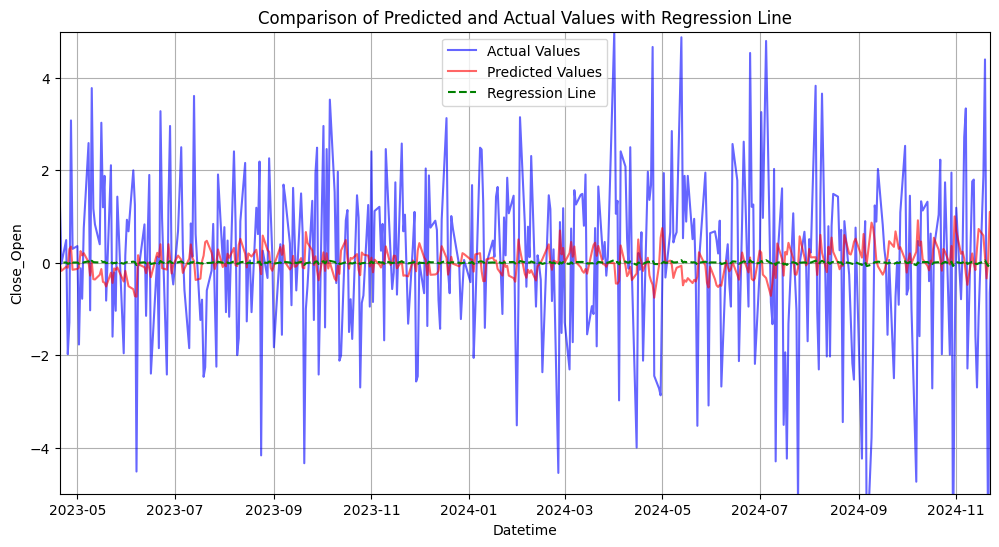

In [17]:
# Line plot for predicted and actual values with a regression line overlapped and zoom functionality

plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(data_test.index[seq_length:], y_test, label="Actual Values", color="blue", alpha=0.6)

# Plot predicted values
plt.plot(data_test.index[seq_length:], pred_Y.flatten(), label="Predicted Values", color="red", alpha=0.6)

# Fit and plot regression line
slope, intercept = np.polyfit(y_test, pred_Y.flatten(), 1)
regression_line = slope * y_test + intercept
plt.plot(data_test.index[seq_length:], regression_line, label="Regression Line", color="green", linestyle="--")

# Add title, labels, and legend
plt.title("Comparison of Predicted and Actual Values with Regression Line")
plt.xlabel("Datetime")
plt.ylabel("Close_Open")
plt.legend()
plt.grid(True)

# Zooming in by setting axis limits (adjust these values based on your data range to zoom)
plt.xlim(data_test.index[int(len(data_test) * 0.1)], data_test.index[int(len(data_test) * 0.9)])  # Zoom on x-axis
plt.ylim(-5, 5)  # Zoom on y-axis - adjust based on actual value range

plt.show()

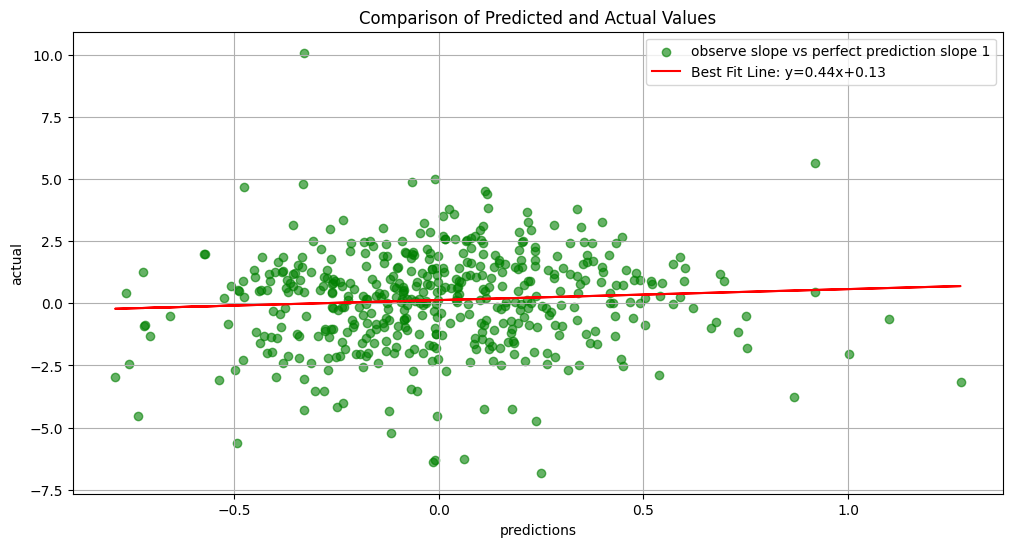

In [18]:
#correlation

plt.figure(figsize=(12, 6))
plt.scatter(pred_Y.flatten(), y_test, color="green", label="observe slope vs perfect prediction slope 1", alpha=0.6)

slope, intercept = np.polyfit(pred_Y.flatten(), y_test, 1)
best_fit_line = slope * pred_Y.flatten()+ intercept
plt.plot(pred_Y.flatten(), best_fit_line, label=f"Best Fit Line: y={slope:.2f}x+{intercept:.2f}", color="red")

plt.title("Comparison of Predicted and Actual Values")
plt.xlabel("predictions")
plt.ylabel("actual")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
slope, intercept = np.polyfit(pred_Y.flatten(), y_test, 1)

In [20]:
print(slope, intercept)

0.4419989626965023 0.13080231920607316


In [21]:
# Initial investment
initial_investment = 100000  # starting with $100,000
capital = initial_investment
pnl= []
principal  =[]
daily_change= 0
n=len(pred_Y)
i =0
# Iterate over predicted and actual values
for pred, actual in zip(pred_Y.flatten(), y_test):
    # If predicted is positive, it's a "buy" strategy
    # If predicted is negative, it's a "sell" strategy
    if pred > 0:
        # Calculate profit/loss for a "buy" strategy
       daily_change = (actual) * capital / df.iloc[-n+i]['Open']     #100 can be replaced open

    elif pred < 0:
        # Calculate profit/loss for a "sell" strategy
        daily_change = (- actual) * capital / df.iloc[-n+i]['Open']  #100 can be replaced open
    capital += daily_change
    pnl.append(daily_change)
    principal.append(capital)
    i+=1

# Calculate final P&L percentage
final_pl_percentage = ((capital - initial_investment) / initial_investment) * 100

print(f"Final Amount: ${capital:.2f}")
print(f"Total Percentage P&L: {final_pl_percentage:.2f}%")



Final Amount: $193979.17
Total Percentage P&L: 93.98%


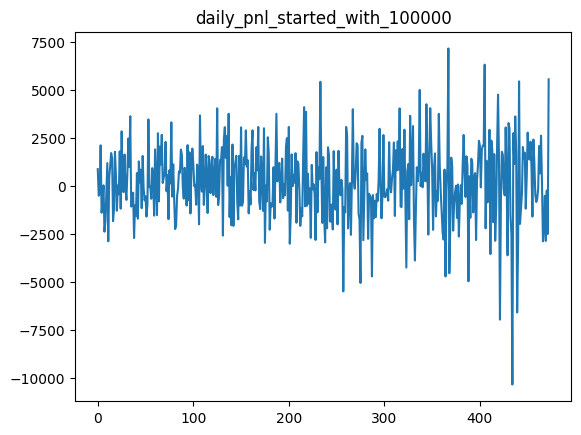

In [22]:
plt.plot(pnl)
plt.title("daily_pnl_started_with_100000")
plt.show()

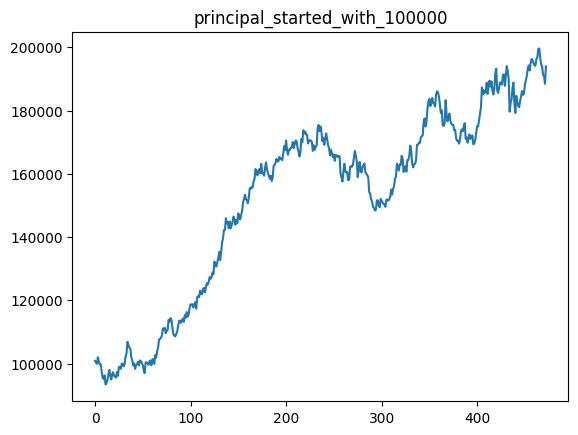

In [23]:
plt.plot(principal)
plt.title("principal_started_with_100000")
plt.show()

In [24]:


def build_gru_model(input_shape):
    model = Sequential([
        GRU(64, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

gru_model = build_gru_model(X.shape[1:])
gru_model.summary()


C:\Users\PC\.venvs\venv_py_3_11\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,929 (50.50 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
gru_model.fit(X_train, y_train, epochs=10, batch_size=32,
              validation_data=(X_val, y_val), verbose=1)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.5923 - val_loss: 4.1887
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5699 - val_loss: 4.2111
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5649 - val_loss: 4.2239
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5739 - val_loss: 4.2256
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.4863 - val_loss: 4.2205
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5615 - val_loss: 4.2295
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5826 - val_loss: 4.2400
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.5497 - val_loss: 4.2375
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5566 - val_loss: 4.2104
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5334 - val_loss: 4.2731


In [26]:
pred_gru = gru_model.predict(X_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [27]:
print(pred_gru.shape)
print(y_test.shape)

(473, 1)
(473,)


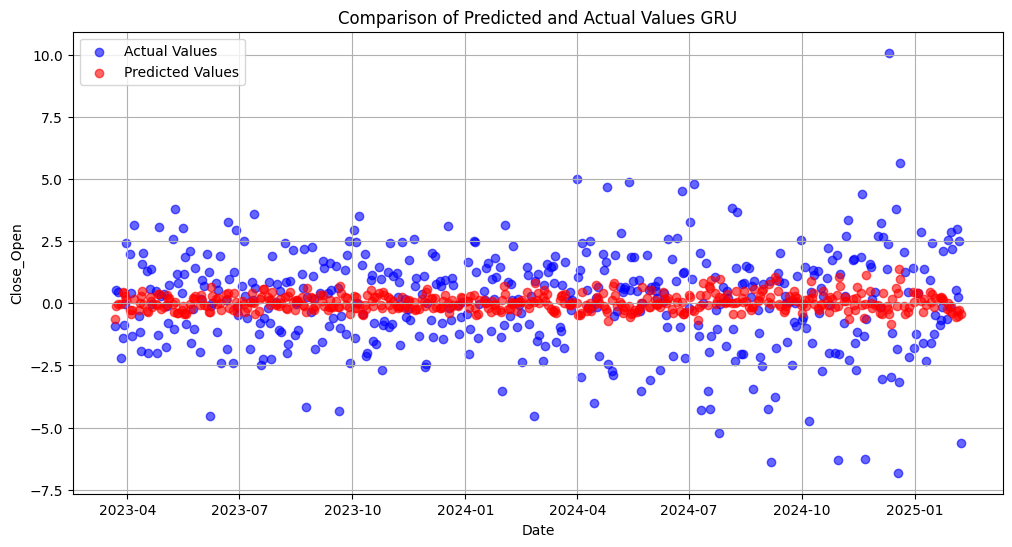

In [28]:
# Scatter plot to compare predictions with actual values in data_test

plt.figure(figsize=(12, 6))
plt.scatter(data_test.index[seq_length:], y_test, label="Actual Values", color="blue", alpha=0.6)
plt.scatter(data_test.index[seq_length:], pred_gru.flatten(), label="Predicted Values", color="red", alpha=0.6)
plt.title("Comparison of Predicted and Actual Values GRU")
plt.xlabel("Date")
plt.ylabel("Close_Open")
plt.legend()
plt.grid(True)
plt.show()

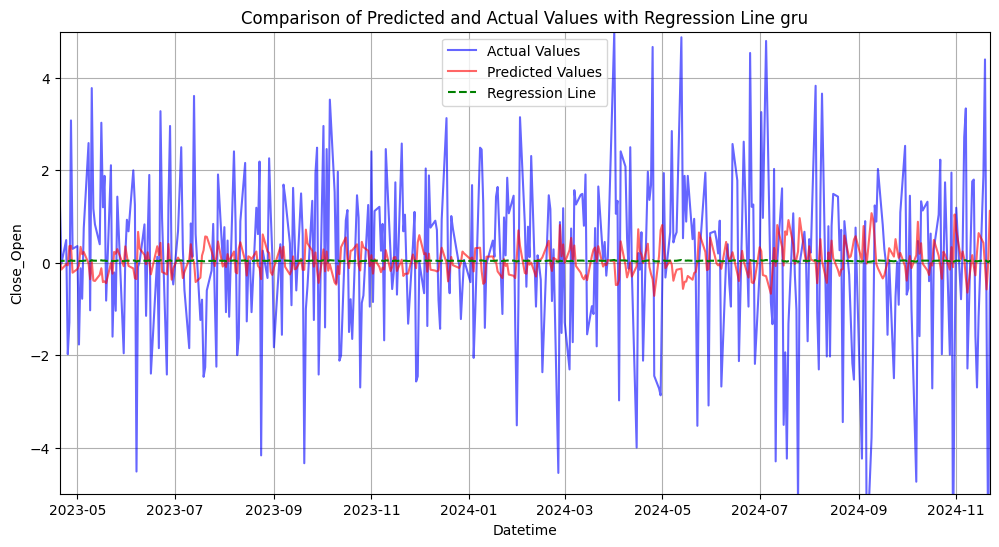

In [29]:
# Line plot for predicted and actual values with a regression line overlapped and zoom functionality

plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(data_test.index[seq_length:], y_test, label="Actual Values", color="blue", alpha=0.6)

# Plot predicted values
plt.plot(data_test.index[seq_length:], pred_gru.flatten(), label="Predicted Values", color="red", alpha=0.6)

# Fit and plot regression line
slope, intercept = np.polyfit(y_test, pred_gru.flatten(), 1)
regression_line = slope * y_test + intercept
plt.plot(data_test.index[seq_length:], regression_line, label="Regression Line", color="green", linestyle="--")

# Add title, labels, and legend
plt.title("Comparison of Predicted and Actual Values with Regression Line gru")
plt.xlabel("Datetime")
plt.ylabel("Close_Open")
plt.legend()
plt.grid(True)

# Zooming in by setting axis limits (adjust these values based on your data range to zoom)
plt.xlim(data_test.index[int(len(data_test) * 0.1)], data_test.index[int(len(data_test) * 0.9)])  # Zoom on x-axis
plt.ylim(-5, 5)  # Zoom on y-axis - adjust based on actual value range

plt.show()

In [30]:
# Initial investment
initial_investment = 100000  # starting with $100,000
capital = initial_investment
pnl= []
principal  =[]
daily_change= 0
n=len(pred_Y)
i =0
# Iterate over predicted and actual values
for pred, actual in zip(pred_gru.flatten(), y_test):
    # If predicted is positive, it's a "buy" strategy
    # If predicted is negative, it's a "sell" strategy
    if pred > 0:
        # Calculate profit/loss for a "buy" strategy
       daily_change = (actual) * capital / df.iloc[-n+i]['Open']

    elif pred < 0:
        # Calculate profit/loss for a "sell" strategy
        daily_change = (- actual) * capital / df.iloc[-n+i]['Open']
    capital += daily_change
    pnl.append(daily_change)
    principal.append(capital)
    i+=1

# Calculate final P&L percentage
final_pl_percentage = ((capital - initial_investment) / initial_investment) * 100

print(f"Final Amount: ${capital:.2f}")
print(f"Total Percentage P&L: {final_pl_percentage:.2f}%")



Final Amount: $170045.14
Total Percentage P&L: 70.05%


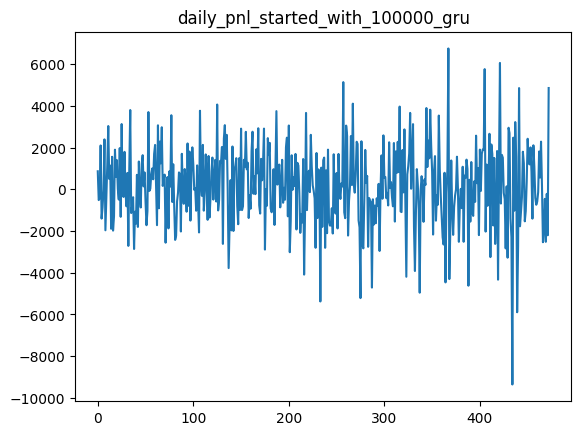

In [32]:
plt.plot(pnl)
plt.title("daily_pnl_started_with_100000_gru")
plt.show()

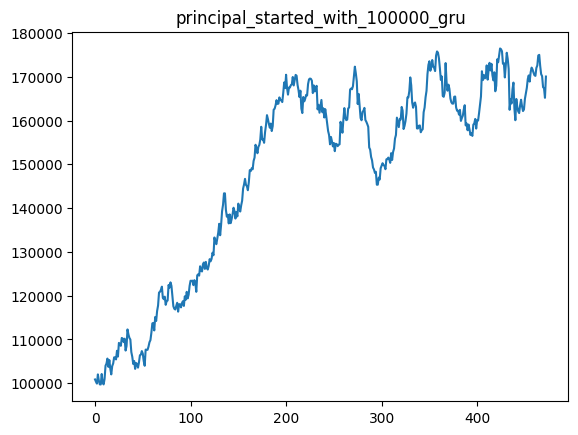

In [33]:
plt.plot(principal)
plt.title("principal_started_with_100000_gru")
plt.show()

In [34]:
from tcn import TCN

def build_tcn_model(input_shape):
    model = Sequential([
        TCN(input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

tcn_model = build_tcn_model(X.shape[1:])
tcn_model.summary()


C:\Users\PC\.venvs\venv_py_3_11\Lib\site-packages\tcn\tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn (TCN)                       │ (None, 64)             │       136,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,321 (532.50 KB)

 Trainable params: 136,321 (532.50 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
tcn_model.fit(X_train, y_train, epochs=10, batch_size=32,
              validation_data=(X_val, y_val), verbose=1)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 11.1904 - val_loss: 7.0581
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.8317 - val_loss: 5.7610
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.5815 - val_loss: 5.4725
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.4418 - val_loss: 5.3342
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.3781 - val_loss: 5.3594
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.3038 - val_loss: 5.3201
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.2851 - val_loss: 5.6289
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2307 - val_loss: 5.4649
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2247 - val_loss: 5.8863
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1871 - val_loss: 5.4731


In [36]:
pred_tcn = tcn_model.predict(X_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


In [37]:
pred_tcn.shape

(473, 1)

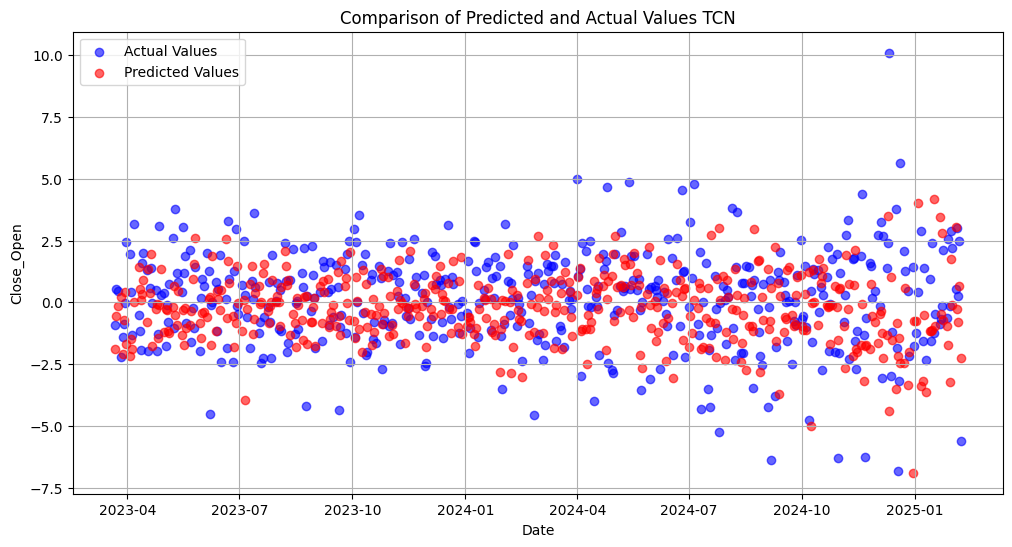

In [38]:
# Scatter plot to compare predictions with actual values in data_test

plt.figure(figsize=(12, 6))
plt.scatter(data_test.index[seq_length:], y_test, label="Actual Values", color="blue", alpha=0.6)
plt.scatter(data_test.index[seq_length:], pred_tcn.flatten(), label="Predicted Values", color="red", alpha=0.6)
plt.title("Comparison of Predicted and Actual Values TCN")
plt.xlabel("Date")
plt.ylabel("Close_Open")
plt.legend()
plt.grid(True)
plt.show()

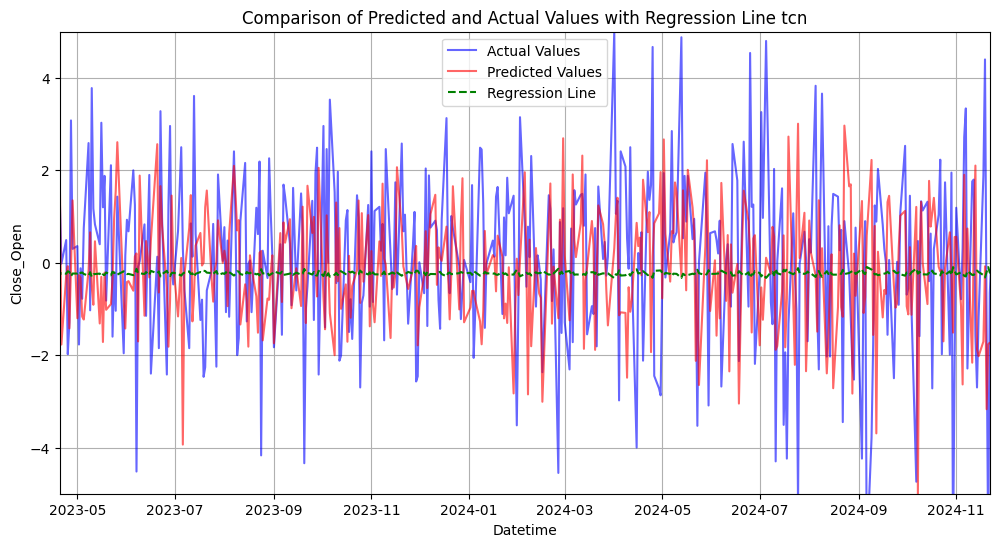

In [39]:
# Line plot for predicted and actual values with a regression line overlapped and zoom functionality

plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(data_test.index[seq_length:], y_test, label="Actual Values", color="blue", alpha=0.6)

# Plot predicted values
plt.plot(data_test.index[seq_length:], pred_tcn.flatten(), label="Predicted Values", color="red", alpha=0.6)

# Fit and plot regression line
slope, intercept = np.polyfit(y_test, pred_tcn.flatten(), 1)
regression_line = slope * y_test + intercept
plt.plot(data_test.index[seq_length:], regression_line, label="Regression Line", color="green", linestyle="--")

# Add title, labels, and legend
plt.title("Comparison of Predicted and Actual Values with Regression Line tcn")
plt.xlabel("Datetime")
plt.ylabel("Close_Open")
plt.legend()
plt.grid(True)

# Zooming in by setting axis limits (adjust these values based on your data range to zoom)
plt.xlim(data_test.index[int(len(data_test) * 0.1)], data_test.index[int(len(data_test) * 0.9)])  # Zoom on x-axis
plt.ylim(-5, 5)  # Zoom on y-axis - adjust based on actual value range

plt.show()

In [41]:
# Initial investment
initial_investment = 100000  # starting with $100,000
capital = initial_investment
pnl= []
principal  =[]
daily_change= 0
n=len(y_test)
i =0
# Iterate over predicted and actual values
for pred, actual in zip(pred_tcn.flatten(), y_test):
    # If predicted is positive, it's a "buy" strategy
    # If predicted is negative, it's a "sell" strategy
    if pred > 0:
        # Calculate profit/loss for a "buy" strategy
       daily_change = (actual) * capital / df.iloc[-n+i]['Open']

    elif pred < 0:
        # Calculate profit/loss for a "sell" strategy
        daily_change = (- actual) * capital / df.iloc[-n+i]['Open']
    capital += daily_change
    pnl.append(daily_change)
    principal.append(capital)
    i+=1

# Calculate final P&L percentage
final_pl_percentage = ((capital - initial_investment) / initial_investment) * 100

print(f"Final Amount: ${capital:.2f}")
print(f"Total Percentage P&L: {final_pl_percentage:.2f}%")



Final Amount: $67840.57
Total Percentage P&L: -32.16%


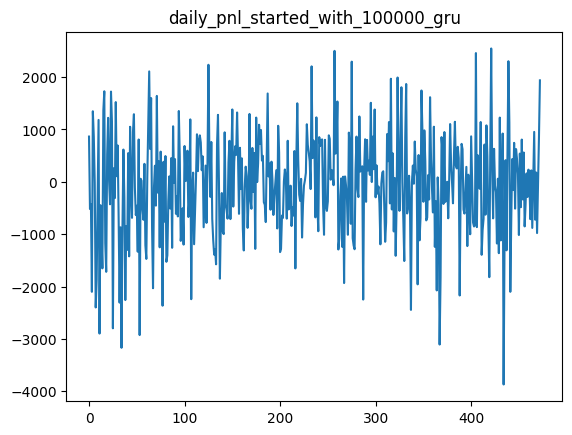

In [43]:
plt.plot(pnl)
plt.title("daily_pnl_started_with_100000_gru")
plt.show()

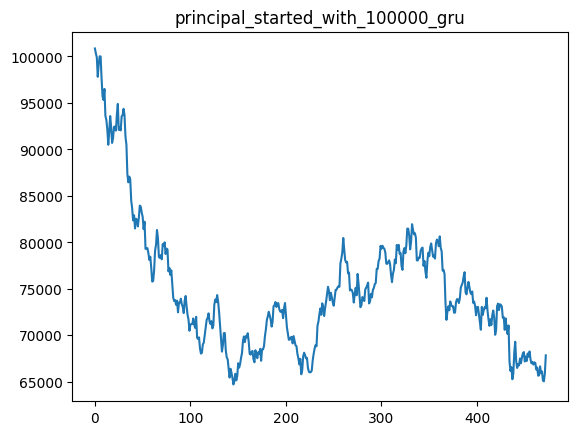

In [44]:
plt.plot(principal)
plt.title("principal_started_with_100000_gru")
plt.show()